# Fundamental Concepts in Data Insight: 
## <font color=indigo> Demo: Unsupervised Learning &amp; Network Science </font>

### Fundamentals for a General Audience

---

QA Ltd. owns the copyright and other intellectual property rights of this material and asserts its moral rights as the author. All rights reserved.

The following code sets up the datasets needed for the demo. 

### Data
We obtain,

* a dataset of messages between possible criminal (gang) suspects
* statistical metrics which describe this messaging behaviour
* a predictive model which connects these metrics to gang rank hierachies

#### NB
This derives from a simulation of messaging behaviour. This simulation is available in a separate notebook. The simulation generates messages; and everything else is statistically derived.

---

In [1]:
from random import sample
import pickle
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import pandas as pd

In [2]:
data    = pickle.load(open('data/suspectgraph.pkl', 'rb'))
metrics = pd.read_csv('data/gmetrics.csv')
model   = pickle.load(open('data/gmodel.pkl', 'rb'))

---

The message log shows communication events between suspects,

In [3]:
sample(data['log'], 3)

[{'subject': '+44 77133 00034',
  'verb': 'SEND',
  'object': '+44 77133 00064',
  'context': {'body': 'ok', 'created': 1621839523.4468455},
  'event': {'created': 1621839523.4468455, 'inserted': None}},
 {'subject': '+44 77133 00094',
  'verb': 'SEND',
  'object': '+44 77133 00057',
  'context': {'body': 'do that!', 'created': 1621839523.4468455},
  'event': {'created': 1621839523.4468455, 'inserted': None}},
 {'subject': '+44 77133 00094',
  'verb': 'SEND',
  'object': '+44 77133 00086',
  'context': {'body': 'how do we do this?', 'created': 1621839523.4468455},
  'event': {'created': 1621839523.4468455, 'inserted': None}}]

From this we can generate a graph whose *nodes* are the suspect IDs (mobile numbers), and whose *edges* are the communication activity,

In [4]:
sample(data['graph'], 3)

[('+44 77133 00034', '+44 77133 00064', {'freq': 1}),
 ('+44 77133 00057', '+44 77133 00094', {'freq': 2}),
 ('+44 77133 00064', '+44 77133 00094', {'freq': 1})]

We can vizulize this graph,

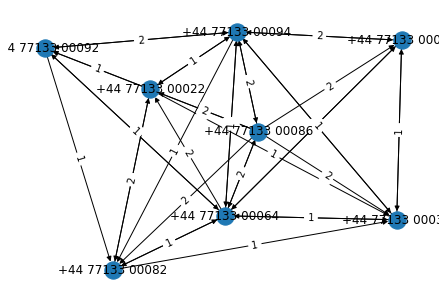

In [5]:
G = nx.from_edgelist(data['graph'], nx.DiGraph)

nx.draw(G, pos := nx.spring_layout(G), with_labels=True)
nx.draw_networkx_edge_labels(G,pos,
    edge_labels=nx.get_edge_attributes(G,'freq'));

The inferential challenge is to assign each node a *rank* within a possible gang hierachy. To do this we compute *metrics* on this graph,

In [6]:
metrics

,node,degree_in,degree_out,freq_in,freq_out
0,+44 77133 00092,0.142857,0.107143,0.103448,0.086207
1,+44 77133 00094,0.214286,0.250000,0.155172,0.224138
2,+44 77133 00086,0.071429,0.250000,0.051724,0.241379
3,+44 77133 00064,0.214286,0.250000,0.155172,0.189655
4,+44 77133 00057,0.142857,0.107143,0.120690,0.068966
5,+44 77133 00082,0.178571,0.107143,0.137931,0.051724
6,+44 77133 00022,0.142857,0.142857,0.120690,0.086207
7,+44 77133 00034,0.214286,0.107143,0.155172,0.051724


Here these metrics represent, for each suspect,

* **degree in** 
    * number of people *sent* messages **to** / total possible
* **degree out**
    * number of people *received* messages **from**  / total possible
* **freq in** 
    * number of messages received / total sent in network
* **freq out**
    * number of messages sent / total sent in network

These metrics are computed in an "unsupervised manner": they merely summarise patterns in data we can already observe. 

We can use these metrics in a supervised machine learning model to *predict* ranks,

In [9]:
features = metrics.copy()
nodes = features.pop('node')
predictions = model.predict(features)

In [10]:
predictions

array(['Commander', 'Senior', 'Senior', 'Relay', 'Frontline', 'Frontline',
       'Frontline', 'Frontline'], dtype=object)

For the sake of clairty, we can put these in a table alongside the original suspect IDs,

In [11]:
ranks = ['Commander', 'Senior', 'Relay', 'Frontline']
result = pd.DataFrame([ {"node": n, "rank": ranks.index(p), "role": p} 
    for n, p in zip(nodes, predictions)
])

result

,node,rank,role
0,+44 77133 00092,0,Commander
1,+44 77133 00094,1,Senior
2,+44 77133 00086,1,Senior
3,+44 77133 00064,2,Relay
4,+44 77133 00057,3,Frontline
5,+44 77133 00082,3,Frontline
6,+44 77133 00022,3,Frontline
7,+44 77133 00034,3,Frontline


### Aside: Visualizing the Hierachy

With some extra steps we can visualize the table above as a hierachical graph ("tree"),

In [12]:
levels = [[ node for (i, node, rank, role) in result.to_records() if rank == r] for r, _ in enumerate(ranks)]
tree = []
for i in range(len(levels) - 1):
    for up in levels[i]:
        for down in levels[i + 1]:
            tree.append((up, down))

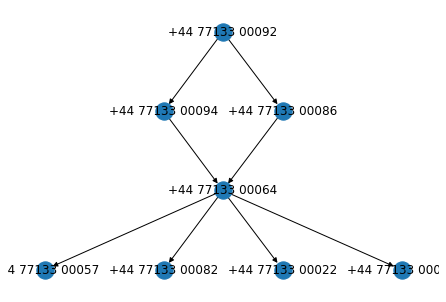

In [15]:

nx.draw(H:=nx.from_edgelist(tree, nx.DiGraph), graphviz_layout(H, prog='dot'), with_labels=True)
